### Import the GitHub Project

In [386]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 421 (delta 43), reused 34 (delta 15), pack-reused 334
Receiving objects: 100% (421/421), 55.23 MiB | 28.55 MiB/s, done.
Resolving deltas: 100% (237/237), done.


### Install Dependencies
---
- pytorch (1.12.1)
- torchvision (0.13.1)
---
- pytorch3d
---
- SMPL
- chumpy

In [354]:
import os
import sys

In [355]:
# install torch
try:
    import torch
    if torch.__version__ != "1.12.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [356]:
# install torchvision
try:
    import torchvision
    if torchvision.__version__ != "0.13.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [357]:
# install pytorch3d
import torch, torchvision

try:
    import pytorch3d
except ModuleNotFoundError:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install pytorch3d

In [358]:
# install SMPL dependencies
!pip install smplpytorch
!pip install chumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [359]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tlco5f1z
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-tlco5f1z


### GPU

In [360]:
torch.cuda.is_available()

True

In [361]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [362]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

### Local Imports 

In [363]:
from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory

from project.rendering import CamerasFactory, Renderer

from project.clip import CLIPwrapper

from project.plots import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SMPL

In [364]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(faces):
  nfaces = len(faces[0])
  texture = txfactory.from_facecolor(nfaces=nfaces, facecolor=(0.77255, 0.54902, 0.52157))
  return texture
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, not used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
mesh = smpl_model.mesh(theta=pose_vect, beta=shape_vect)

### Differentiable Renderer

In [406]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# create a camera using the cameras factory
camera = camsfactory.fov_persp_scs(coords=(2.25, 0, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=camera)
# render the textured mesh generated by SMPL
image = renderer.render(mesh)

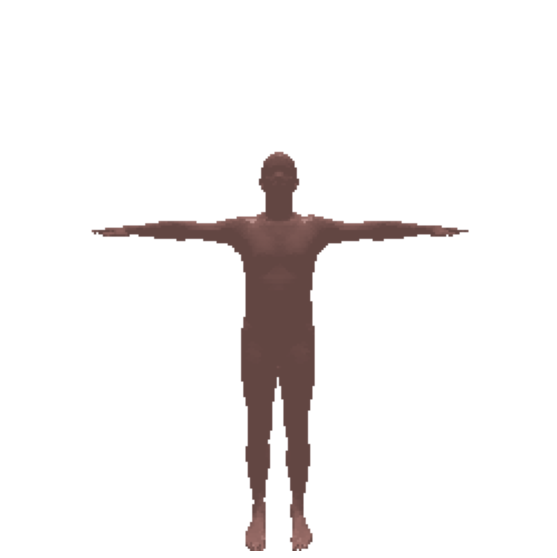

In [407]:
# a quick visualization of the rendered mesh
plot_image_t(image);

### CLIP

In [408]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [409]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

In [410]:
def info_str(tensor):
    print("### tensor info:")
    print("shape: " + str(tensor.shape))
    print("device: " + str(tensor.get_device()))
    print("requires grad: " + str(tensor.requires_grad))
    print("### end of tensor info\n")

In [411]:
info_str(image)

### tensor info:
shape: torch.Size([1, 244, 244, 4])
device: 0
requires grad: False
### end of tensor info



In [412]:
info_str(clip_model.proc_image_t(image))

### tensor info:
shape: torch.Size([3, 244, 244])
device: 0
requires grad: False
### end of tensor info



In [413]:
info_str(clip_model.image_embedding(image))

### tensor info:
shape: torch.Size([1, 512])
device: 0
requires grad: True
### end of tensor info



In [414]:
info_str(clip_model.prompt_embedding(prompt="abcd, efghij''-klmnopqrst uvwxyz 0123 456 789"))

### tensor info:
shape: torch.Size([1, 512])
device: 0
requires grad: True
### end of tensor info



In [415]:
import torch.nn as nn
cos_sim = nn.CosineSimilarity(dim=1, eps=1e-8)
cos_dist = lambda x, y: 1 - cos_sim(x, y)
cos_dist(clip_model.image_embedding(image), clip_model.prompt_embedding("""
a brown mannequin in a white background. The mannequin is looking upfront. The mannequin is standing up on his feet. Both the mannequin's hands are up."""))

tensor([0.6758], device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)

### Optimization

In [416]:
from project.optimization import OptimEnv, init_weights
from project.model import compose

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [417]:
clip_model.train() # set clip in training mode
model = compose(smpl=smpl_model, renderer=renderer, clip=clip_model, 
                #prompt="This is a grey mannequin in a white background. He is standing on his feet. His hands are up.")
                prompt="""
                a brown mannequin in a white background. The mannequin is looking upfront. The mannequin is standing up on his feet. Both the mannequin's hands are up.""")

In [418]:
pose, shape = init_weights(device=dev) # weights used in optimization

In [419]:
torch.norm(pose).item()

0.0

In [420]:
torch.norm(shape).item()

3.1622776985168457

In [421]:
optimenv = OptimEnv(model=model, params=[pose, shape], lr=1e-3) # we do not optimize with respect to the shape
result = optimenv.optimize(pose=pose, shape=shape, n_passes=1000, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}})

In [422]:
torch.norm(pose).item()

2.4098575115203857

In [423]:
torch.norm(shape).item()

3.8201756477355957

In [424]:
result["tracked"]["losses"]["loss"].min(), result["tracked"]["losses"]["loss"].max() 

(0.6630859375, 0.67578125)

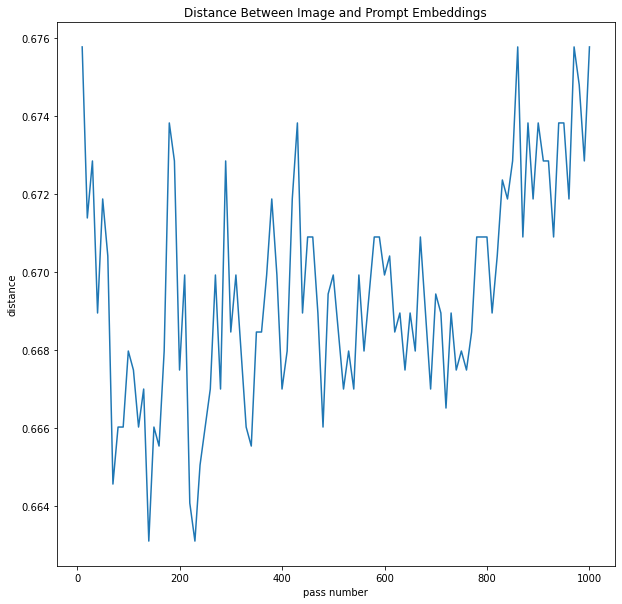

In [425]:
plot_losses(result["tracked"]["losses"])

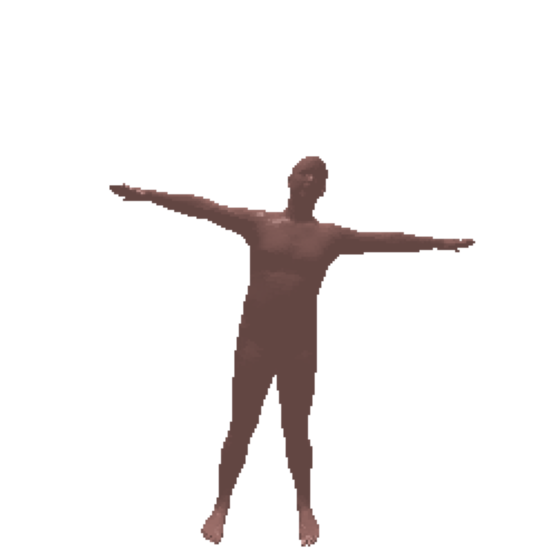

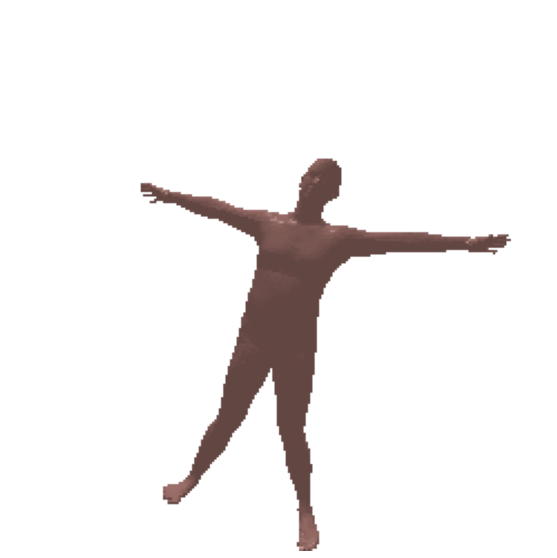

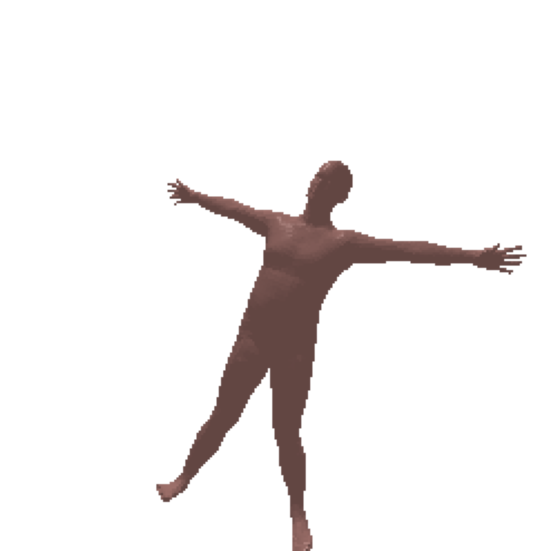

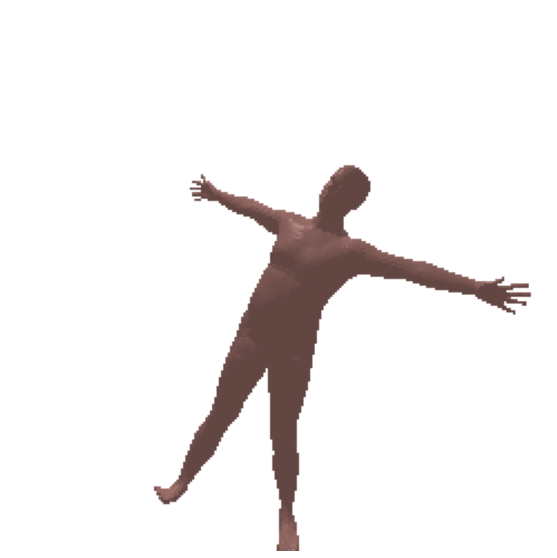

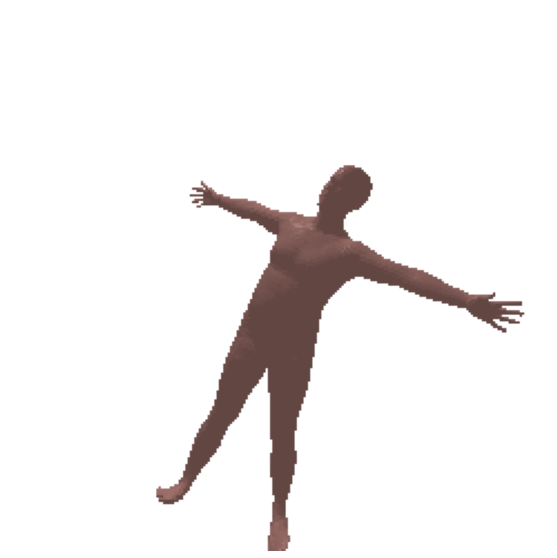

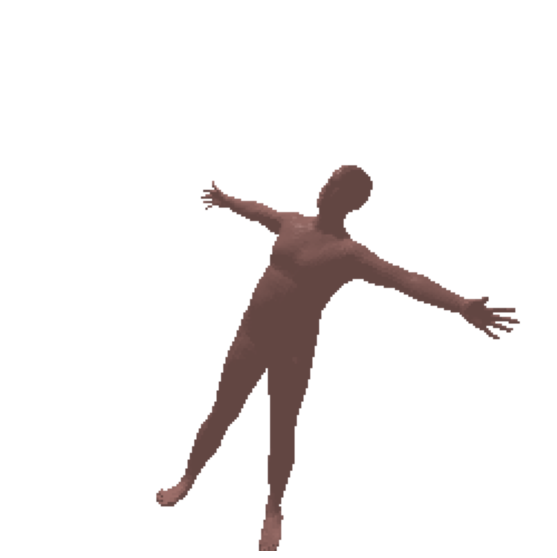

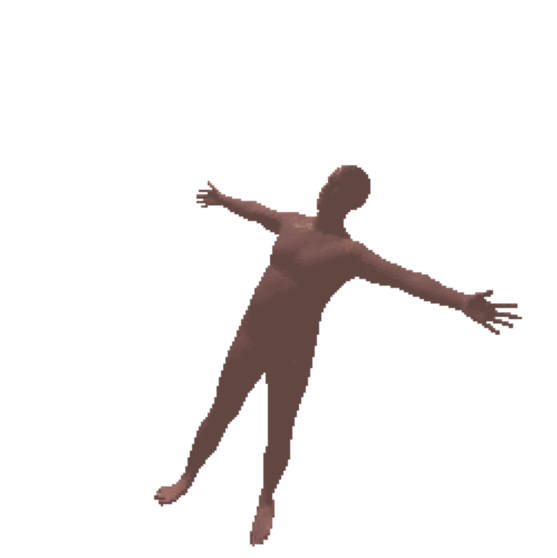

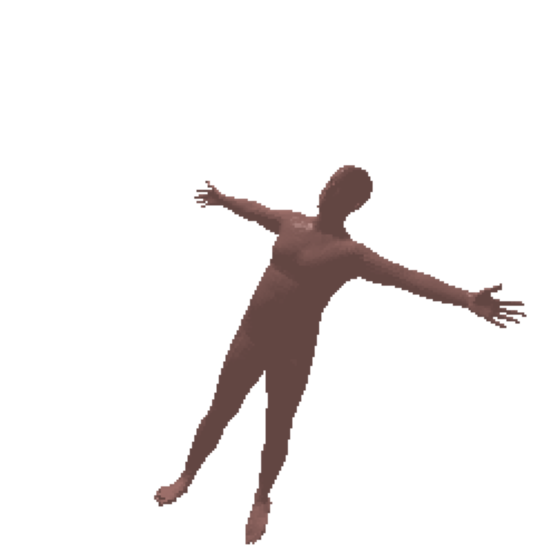

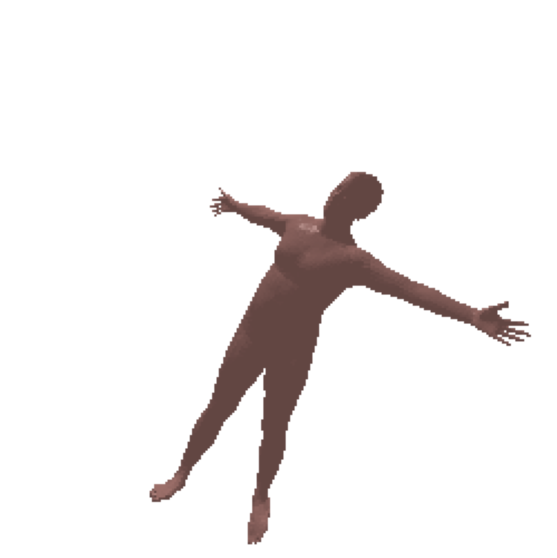

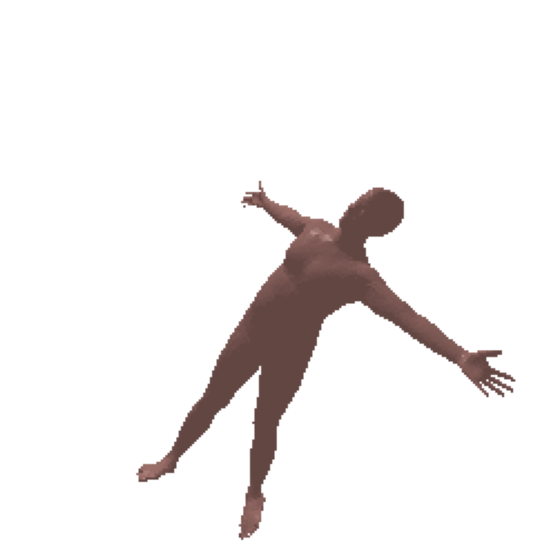

In [430]:
# create a camera using the cameras factory
camera2 = camsfactory.fov_persp_scs(coords=(2.25, 0, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer2 = Renderer(device=dev, cameras=camera2)

for intermediate_pose in result["tracked"]["poses"]["pose"]:
  intermediate_pose = intermediate_pose.to(dev)
  # create the mesh
  mesh2 = smpl_model.mesh(theta=intermediate_pose, beta=shape)
  image2 = renderer2.render(mesh2)
  # a quick visualization of the rendered mesh
  plot_image_t(image2)

In [431]:
pose, shape = init_weights(device=dev) # weights used in optimization

In [455]:
clip_model.train() # set clip in training mode
model2 = compose(smpl=smpl_model, renderer=renderer, clip=clip_model, 
                #prompt="This is a grey mannequin in a white background. He is standing on his feet. His hands are up.")
                prompt="""
                a brown mannequin in a white background. The mannequin is lying on the ground. The mannequin's hands are on its hips""")

In [ ]:
optimenv = OptimEnv(model=model2, params=[pose, shape], lr=1e-3) # we do not optimize with respect to the shape
result2 = optimenv.optimize(pose=pose, shape=shape, n_passes=1000, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}})

In [ ]:
result2["tracked"]["losses"]["loss"].min(), result["tracked"]["losses"]["loss"].max() 

In [ ]:
plot_losses(result2["tracked"]["losses"])

In [ ]:
# create a camera using the cameras factory
camera2 = camsfactory.fov_persp_scs(coords=(2.25, 0, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer2 = Renderer(device=dev, cameras=camera3)

for intermediate_pose in result2["tracked"]["poses"]["pose"]:
  intermediate_pose = intermediate_pose.to(dev)
  # create the mesh
  mesh2 = smpl_model.mesh(theta=intermediate_pose, beta=shape)
  image2 = renderer2.render(mesh2)
  # a quick visualization of the rendered mesh
  plot_image_t(image3)

In [446]:
clip_model.train() # set clip in training mode
model3 = compose(smpl=smpl_model, renderer=renderer, clip=clip_model, 
                #prompt="This is a grey mannequin in a white background. He is standing on his feet. His hands are up.")
                prompt="""
                a brown mannequin in a white background. The mannequin is falling on its back.""")

In [447]:
optimenv = OptimEnv(model=model3, params=[pose, shape], lr=1e-3) # we do not optimize with respect to the shape
result3 = optimenv.optimize(pose=pose, shape=shape, n_passes=1000, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}})

In [448]:
result3["tracked"]["losses"]["loss"].min(), result["tracked"]["losses"]["loss"].max() 

(0.671875, 0.6787109375)

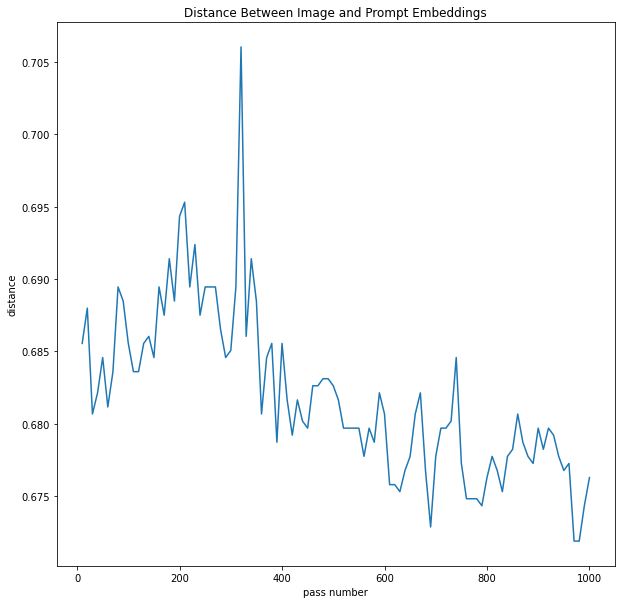

In [449]:
plot_losses(result3["tracked"]["losses"])

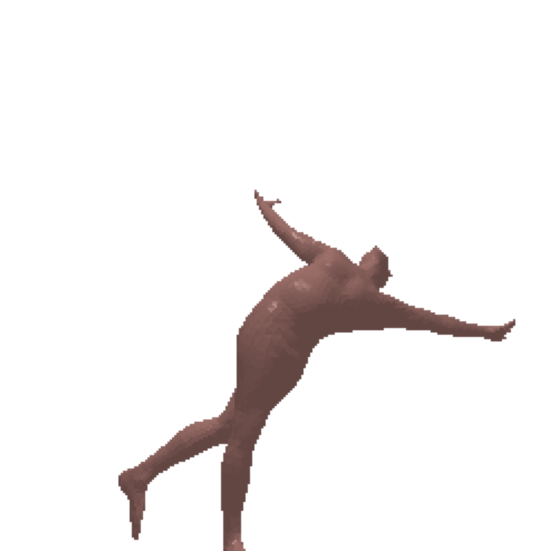

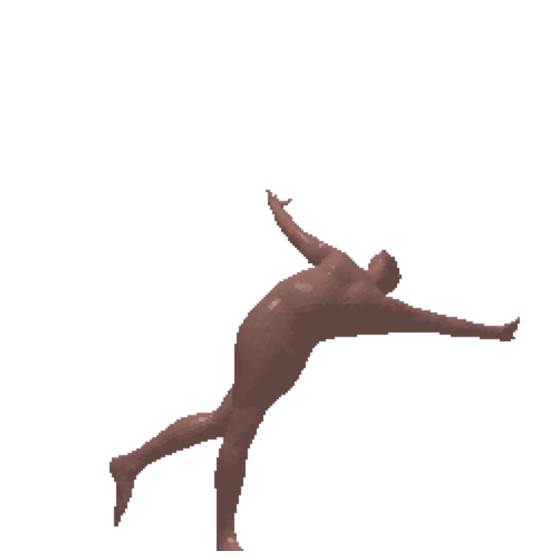

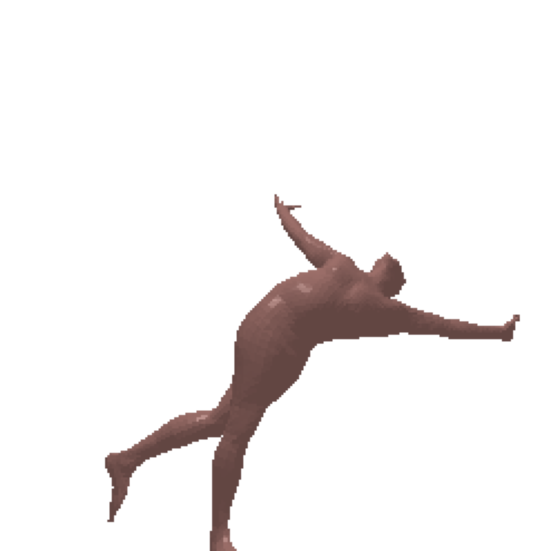

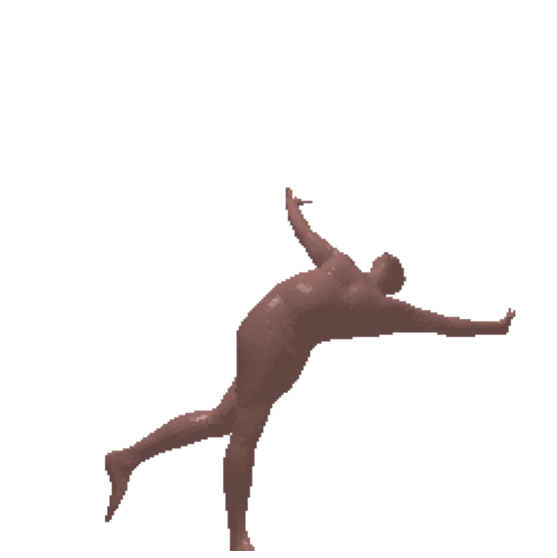

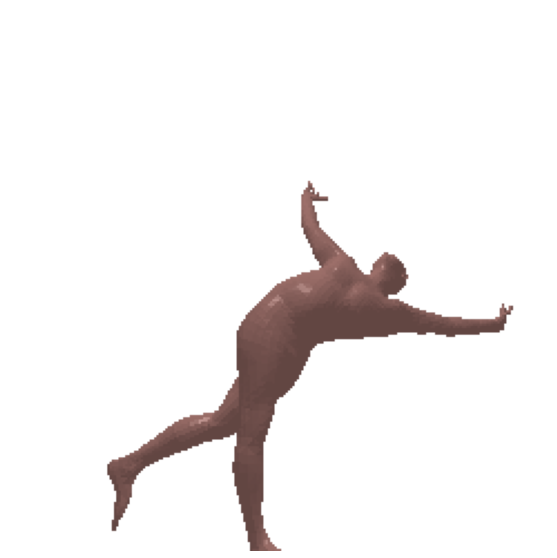

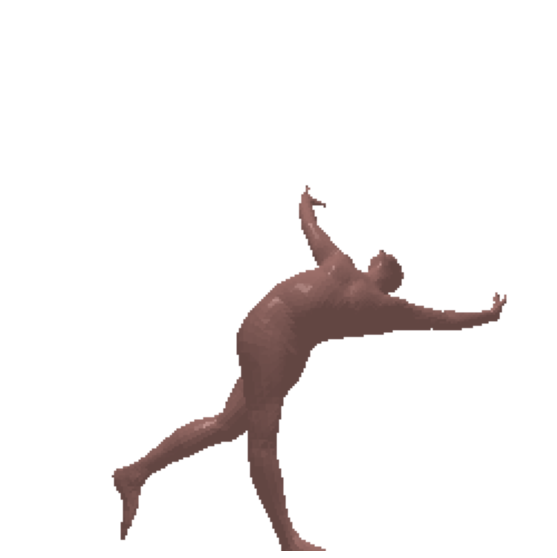

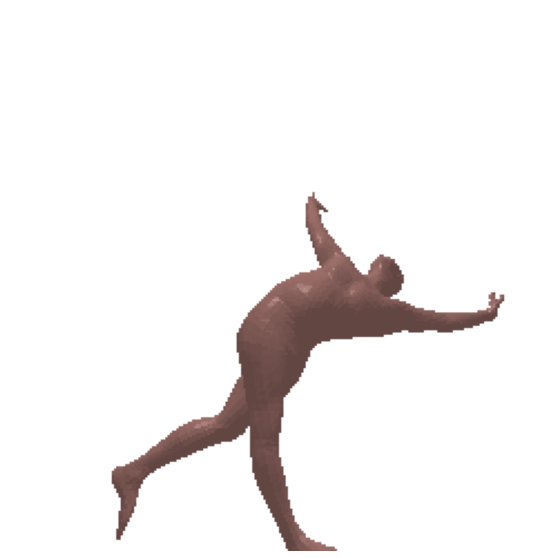

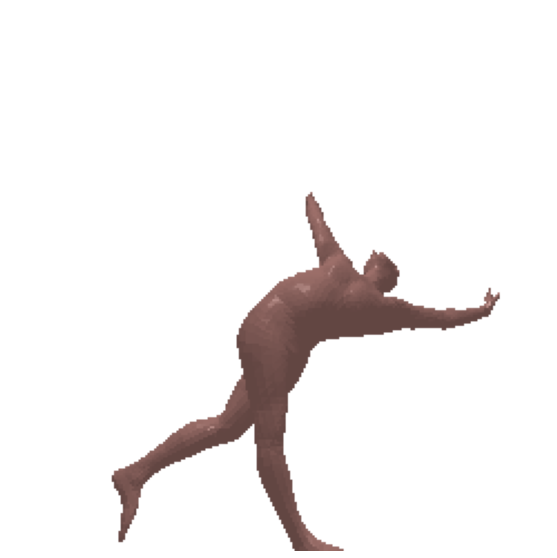

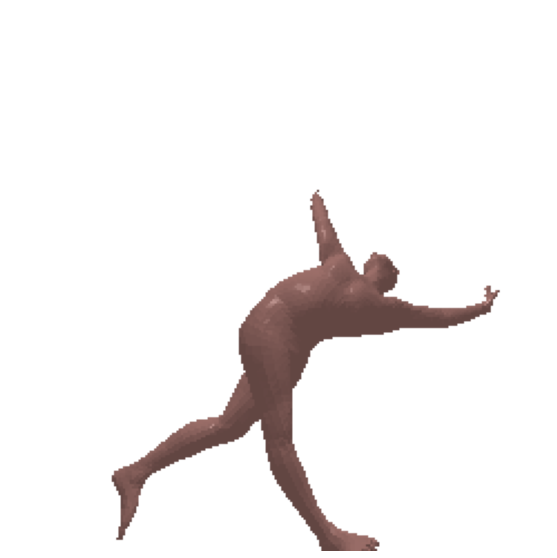

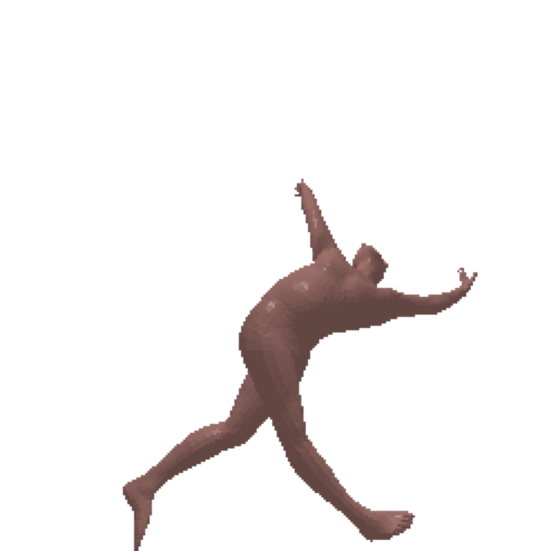

In [454]:
# create a camera using the cameras factory
camera3 = camsfactory.fov_persp_scs(coords=(2.25, -90, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer3 = Renderer(device=dev, cameras=camera3)

for intermediate_pose in result3["tracked"]["poses"]["pose"]:
  intermediate_pose = intermediate_pose.to(dev)
  # create the mesh
  mesh3 = smpl_model.mesh(theta=intermediate_pose, beta=shape)
  image3 = renderer3.render(mesh3)
  # a quick visualization of the rendered mesh
  plot_image_t(image3)